
<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Data Retrieval and Exploration</p>

In [62]:
import requests
from bs4 import BeautifulSoup
import re, urllib, json
import pandas as pd
from collections import defaultdict, Counter
from numpy import unique
from os import listdir, walk
from os.path import isfile, join, getsize
import seaborn as sns
import matplotlib.pyplot as plt

### Wiki pages for all characters


In The Office Wiki, the characters are split into multiple categories. What we first do is go to the landing page where characters are organized into categories. We use the wiki's api and Beautiful Soap to extract these categories and see which characters belong to each one of them. Next, we download the pages of each of the characters, while filtering out the categories we are not intrested in.

In [63]:
baseurl = "https://theoffice.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat = "format=json"

folder = "Data/characters/"

# This function gets the wiki text for a character page and saves it in a file
def get_character_text(name):
    
    content = "prop=revisions&rvprop=content&rvslots=*"
    title = f"titles={name}"
    query = "{0}{1}&{2}&{3}&{4}".format(baseurl,action,title,content,dataformat)

    with open(f'{folder}{name}.txt', 'w') as f:
        
        # Query throguh API to retrieve content, and save
        response = urllib.request.urlopen(query)
        data = response.read()
        text = data.decode('utf-8')
        content = json.loads(text)
        page_id = list(content['query']['pages'].keys())[0]
        text = content['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']
        
        # Remove non-unicode characters
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        
        # Remove references
        references = re.findall(r"<ref(.*?)</ref>",text)
        for ref in references:
            text = text.replace(ref, "")
        text = text.replace("ref","")
        
        f.write(text)

In [64]:
# characters are split across two pages
page_titles = ["https://theoffice.fandom.com/wiki/Category:Characters", "https://theoffice.fandom.com/wiki/Category:Characters?from=Merv+Bronte"]
categories = []
all_characters = []

# Perform queries through the different pages the characters are distributed in
for page_title in page_titles:

    title = f"titles={page_title}"
    query = "{}{}&{}&{}&{}&rvslots=*".format(baseurl, action, content, title, dataformat)

    page = requests.get(page_title)

    soup = BeautifulSoup(page.content, "html.parser")
    character_pattern = re.compile(r'/wiki/(.*)')
    category_pattern = re.compile(r'Category:')
    filter_subcategories = ["Background_Employees", "Clients_of_Dunder_Mifflin", "Main_Characters", "Mentioned_characters", "Voiced_Characters", "Background_Warehouse_Employees", "Dunder_Mifflin_family_members_and_loved_ones", "The_Office_Characters", "Angela's_cats"]
    
    # for each of the characters listed in the characters pages
    for link in soup.find_all("a", {"class": "category-page__member-link"}):

        # capture all the href elements
        href = link.get("href")

        # capture all character names in each href
        name =  character_pattern.match(href).group(1)
        name = name.replace("%27", "'")

        # remove "Categories" which are classifications of characters and not characters themselves
        if category_pattern.match(name):
            categories.append(name)

        # remove specific subcategories which are not characters themselves
        elif name not in filter_subcategories:
            get_character_text(name)
            all_characters.append(name.replace("_", " "))

In [65]:
print(f"There are {len(all_characters)} characters, and each one has its own wiki text file.")

There are 294 characters, and each one has its own wiki text file.


In [66]:
# assign size
wiki_size = 0
 
for path, dirs, files in walk(folder):
    for f in files:
        fp = join(path, f)
        wiki_size += getsize(fp)
 
print(f"The size of all the files combined is {wiki_size} bytes.")

The size of all the files combined is 1273738 bytes.


### Main Dataframe from Wiki

We process the text retrieved before into a DataFrame. Here we determine the characters, the category they belong to, the seasons they appear in and we extract the links to other characters.

Add category to character

In [67]:
baseurl = "https://theoffice.fandom.com/api.php?"
action = "action=query"
list_ = "list=categorymembers"
cmlimit = "cmlimit=500"
dataformat ="format=json"

# Since characters cna only be in one category, we prioritize the category they should belong to
categories = {                
             'Main_Characters': 0,
             'Warehouse_worker': 1,
             'Former_employees': 2,
             'Background_employees': 3,
             'IT_Guys': 4,
             'Family_members': 5,
             'Characters_of_Michael_Scott': 6,
             'Characters_of_Dwight_Schrute': 7,
             'Threat_Level_Midnight_Characters': 8,
             'The_3rd_Floor_Characters': 9,
             'Deceased_characters': 10,
             'Animals': 11,
             'Unseen_Characters': 12,
             'Unnamed': 13, 
             'Dunder_Mifflin_employees':14
             }

In [68]:
# Query characters in each category
queries = []
for category in categories:
    cmtitle = f"cmtitle=Category:{category}"
    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, list_, cmtitle, cmlimit, dataformat)
    queries.append(query)

In [69]:

# for each category, we build the list of characters. We give preference to the categories in the order above, for the characters that fall in
# multiple categories. i.e. Main characters > Warehouse worker > Former employees > etc..

characters_category = {}
for category, query in zip(categories,queries):
    response = urllib.request.urlopen(query)
    data = response.read()
    text = data.decode('utf-8')
    
    json_text = json.loads(text)
    
    category_members = json_text["query"]["categorymembers"]
    
    characters_in_category = [member["title"] for member in category_members]
    
    for character in characters_in_category:
        if character not in characters_category.keys() and character in all_characters:
            characters_category[character] = category

In [70]:
# We set all characters that do not fall under a category to be other

characters_in_other_category = [character for character in all_characters if character not in characters_category.keys()]

for character in characters_in_other_category:
    characters_category[character] = "Other"

In [76]:
# We process character names to remove dashes
files = listdir(folder)
characters = [char[:-4].replace("_", " ") for char in files]

We now want to capture links between characters and seasons they appear in.

In [77]:
def get_seasons(text):
    season_regex = r"\[\[Season (\d)|\d\]\]"
    seasons = re.findall(season_regex, text)
    seasons = [int(i) for i in seasons if i != ""]
    
    return list(unique(seasons))

In [78]:
def get_character_links(text):
    link_regex = r"\[\[(.*?)\]\]"
    
    links = re.findall(link_regex, text)
    
    return [link for link in links if link in characters]

In [79]:
seasons = []
links = []

for character in characters_category.keys():
    filepath = open(folder + character.replace(" ", "_") + ".txt", 'r')
    text = filepath.read()
    
    seasons.append(get_seasons(text))
    links.append(get_character_links(text))

In [80]:
df = pd.DataFrame({"Category" : characters_category.values(), "Links": links, "Seasons": seasons}, index = characters_category.keys())
df_filepath = "Data/dataframe_characters.csv"
df.to_csv(df_filepath, index=True)

In [81]:
df.head()

,Category,Links,Seasons
Andy Bernard,Main_Characters,"[Erin Hannon, Angela Martin, Unnamed Cousin, W...","[3, 4, 5, 6, 7, 8, 9]"
Angela Martin,Main_Characters,"[Dwight Schrute, Robert Lipton, Andy Bernard, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
Clark Green,Main_Characters,"[Pete Miller, Kelly Kapoor, David Wallace, Tod...",[9]
Creed Bratton,Main_Characters,"[Creed Bratton, Michael Scott, Hannah Smoteric...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
Darryl Philbin,Main_Characters,"[Kelly Kapoor, Val Johnson, Jada Philbin, Gwyn...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"


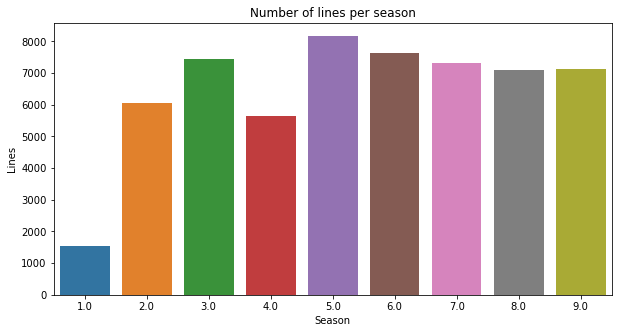

In [82]:
plt.figure(figsize=(10,5))

df_real = df_dialog[df_dialog.deleted == False]

c = Counter(df_real['season'])
sns.barplot(x = list(c.keys()), y = list(c.values()))
plt.xlabel("Season")
plt.ylabel("Lines")
plt.title("Number of lines per season")
plt.show()

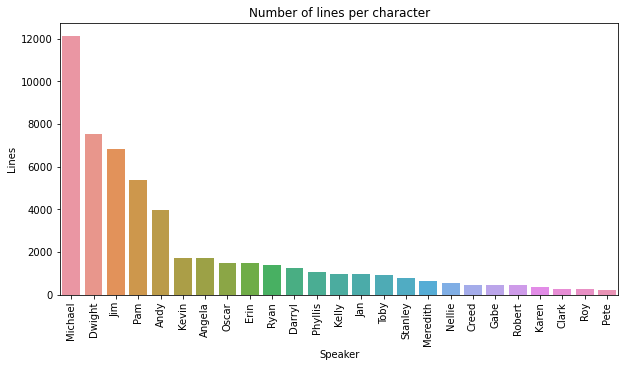

In [61]:
main_characters = df[df.Category == "Main_Characters"].index
main_characters_first_name = [char.split(" ")[0] for char in main_characters]
df_main = df_dialog[[speaker in main_characters_first_name for speaker in df_dialog.speaker]]

plt.figure(figsize=(10,5))
c = Counter(df_main['speaker'])
c = dict(sorted(c.items(), key=lambda item: item[1], reverse = True))
sns.barplot(x = list(c.keys()), y = list(c.values()))
plt.xticks(rotation=90)
plt.xlabel('Speaker')
plt.ylabel("Lines")
plt.title("Number of lines per character")
plt.show()

Each character is one row with a list of links to other characters. This we will expand into new rows for each relationship between the character and its links. This can be done using <code>df.explode()</code>

In [16]:
df_e_filepath = "Data/dataframe_characters_exploded.csv"
df_exploded = df.explode("Links")
df_exploded.to_csv(df_e_filepath)

In [17]:
df_exploded

,Category,Links,Seasons
Andy Bernard,Main_Characters,Erin Hannon,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Angela Martin,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Unnamed Cousin,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Walter Bernard Jr.,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Walter Bernard Sr.,"[3, 4, 5, 6, 7, 8, 9]"
...,...,...,...
W.B. Jones,Other,Kevin Malone,[]
W.B. Jones,Other,Andy Bernard,[]
Wally Amos,Other,NaN,[]
Wesley Silver,Other,Robert Lipton,[9]


In [18]:
df_size = getsize(df_filepath)
print(f"The size of all the files combined is {df_size} bytes.")

The size of all the files combined is 23890 bytes.


### Dialogue for characters

Here we explore The Office script we downloaded.

In [9]:
script_path = "Data/the-office-lines-script.xlsx"
df_dialog = pd.read_excel(script_path, index_col = "id")

In [10]:
df_dialog.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1.0,1.0,1.0,1.0,All right Jim. Your quarterlies look very good...,Michael,False
2.0,1.0,1.0,1.0,"Oh, I told you. I couldn't close it. So...",Jim,False
3.0,1.0,1.0,1.0,So you've come to the master for guidance? Is ...,Michael,False
4.0,1.0,1.0,1.0,"Actually, you called me in here, but yeah.",Jim,False
5.0,1.0,1.0,1.0,"All right. Well, let me show you how it's done.",Michael,False


In [11]:
dialog_size = getsize(script_path)
print(f"The size of all the files combined is {dialog_size} bytes.")

The size of all the files combined is 3256246 bytes.


### Ratings

In this section we explore the ratings from The Office.

In [3]:
ratings_path = "Data/TheOffice_Episodes_IMDb_Ratings.csv"
df_ratings = pd.read_csv(ratings_path)

In [4]:
df_ratings.head()

,season,episode_number,title,airdate,rating,total_votes,desc
0,1,1,Pilot,2005-03-24,7.4,7125,The premiere episode introduces the boss and s...
1,1,2,Diversity Day,2005-03-16,8.3,7020,Michael's off color remark puts a sensitivity ...
2,1,3,Health Care,2005-04-05,7.7,5853,Michael leaves Dwight in charge of picking the...
3,1,4,The Alliance,2005-04-12,8.0,5665,"Just for a laugh, Jim agrees to an alliance wi..."
4,1,5,Basketball,2005-04-19,8.4,6290,Michael and his staff challenge the warehouse ...


In [12]:
rating_size = getsize(ratings_path)
print(f"The size of all the files combined is {rating_size} bytes.")

The size of all the files combined is 43431 bytes.


In [13]:
print(f"The total size of ALL the data is: {(rating_size + wiki_size + df_size + dialog_size)/1000} KB")

NameError: name 'wiki_size' is not defined